# Plant Defense responses to random herbivory events
The goal of this model is to determine if strength/frequency of herbivory events may be sufficent to predict if plants may pursue constitutive or induced defense systems. Model is adapted from Yamamura and Tsuji 1995.

## Imports

In [3]:
import numpy as np
import proplot as pplt
from tqdm import tqdm

## Dynamics
In this model there are two state variables: Vegetative biomass, $C$, (i.e. a mix of leaves, stem, reproductive parts), and defensive biomass, $D$, (for the purposes of this model, this best represents chemical defenses that can be simplistically viewed as being evenly intermixed throughout the plant). Both types of biomass increases according to the amount of new resources captured by vegetative biomass (subject to a control that splits resources between biomass types) and decreases proportional to herbivory (which is influenced by the background herbivore threat and proportion of defense biomass to total biomass). A feedback control $a(C, D, t)$ determines the investment in new vegetative biomass (lossless) and defensive biomass (diminishing returns for higher proportions of production invested), subject to the constraint $a \in [0, 1]$. Now define $C(0) = C_0$ and $D(0) = D_0$, then the dynamics of the model can be described by
\begin{align*}
    \frac{dC}{dt} & = (1 - a(C, D, t))g(C) - h\left(\frac{D}{C+D}\right)C \\
    \frac{dD}{dt} & = a(C, D, t)(1 - \alpha a(C, D, t))g(C) - h\left(\frac{D}{C+D}\right)D
\end{align*}
Where $g(C)$ is the production, $h(x)$ is the rate of herbivory based on the proportion of defensive investment, and $\alpha$ is constant describing the strength of diminishing returns on defensive investment. 

Furthermore, we will assume the plant is trying to maximize average fitness and that fitness is correlated to the amount of vegetative biomass present at the end of the season. Thus, if $T$ is the terminal time, we consider our terminal 'cost' to be $q(C, D) = C$ and that there is no running cost. Then, the cost of a set of controls is simply: $J(C, D, t, a(\cdot)) = q(C(T), D(T)) = C(T)$, and the optimal control will maximize this cost. Let $u(C, D, t)$ denote the optimal value for a point in space-time, then by tail-optimality (and $\tau > t$)

\begin{align*}
    u(C(t), D(t), t) & = \sup_{a(\cdot)} C(T) \\
      & = \sup_{a(\cdot)} u(C(\tau), D(\tau), \tau) \\
      & = \sup_{a(\cdot)} \left( u(C(t), D(t), t) + \tau(u_t(C(t), D(t), t) + u_C(C(t), D(t), t)\frac{dC}{dt} + u_D(C(t), D(t), t)\frac{dD}{dt} + o(\tau^2) \right) \\
    0 & = \sup_{a(\cdot)} \left(\tau(u_t(C(t), D(t), t) + u_C(C(t), D(t), t)\frac{dC}{dt} + u_D(C(t), D(t), t)\frac{dD}{dt}) + o(\tau^2) \right) \\
    0 & = \sup_{a(\cdot)} \left(u_t(C(t), D(t), t) + u_C(C(t), D(t), t)\frac{dC}{dt} + u_D(C(t), D(t), t)\frac{dD}{dt} + o(\tau) \right) \\
    0 & = u_t(C(t), D(t), t) + \sup_{a(\cdot)} \left(u_C(C(t), D(t), t)\frac{dC}{dt} + u_D(C(t), D(t), t)\frac{dD}{dt} \right) \\
\end{align*}

For the purposes of this analysis, we will give the folowing functional forms to production and herbivory
\begin{align*}
    g(C) & = GC \\
    h(x) & = Re^{-Kx}
\end{align*}
Where $G$ is the rate of production of new biomass per unit vegetative biomass, $R$ is the background rate of herbivory, and $K$ describes the rate of decrease in the rate of herbivory as the concetration of defense biomass increases. Note that in addition to decreasing returns on defense accumulation depending on amount of resources invested, there is also diminishing returns on herbivory reduction as proportion of defense increases.

Suppose we imposed a lattice on the spacetime domain, indexed by $i$ in the $C$ direction, $j$ in the $D$ direction, $n$ in the $t$ direction and the discretization $U^n_{i,j} = u(C_i, D_j, t_n)$. Then, using a Markov decision process approximation of our PDE with
\begin{align*}
    f^{\pm} & = \max \{ \pm \frac{dC}{dt}, 0\} \\
    g^{\pm} & = \max \{ \pm \frac{dD}{dt}, 0\} \\
    p^{\pm / 0} & = \frac{\tau}{h_C} f^{\pm} \\
    p^{0 / \pm} & = \frac{\tau}{h_D} g^{\pm} \\
    p^{0 / 0} & = 1 - p^{+ / 0} - p^{- / 0} - p^{0 / +} - p^{0 / -}
\end{align*}
yields the following discretization of our HJB PDE that we will use to for numerical solutions.
$$U^n_{i,j} = \max_{a \in [0,1]} \left\{ p^{0/0}U^{n+1}_{i,j} + p^{+/0}U^{n+1}_{i+1,j} + p^{-/0}U^{n+1}_{i-1, j} + p^{0/+}U^{n+1}_{i,j+1} + p^{0/-}U^{n+1}_{i, j-1} \right\}$$

## Define Parameters

In [97]:
# Model Parameters
T = 50         # Length of season
alpha = 0.5    # Strength of diminishing returns of proportion of production devoted to defense
G = 0.08      # Rate of production of new biomass per unit vegatative biomass
R = 0.06       # Background herbivory rate per unit biomass
K = 3.5        # Rate of decrease in herbviory as proportion of defense increases

def dC_dt(C, D, a):
    return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C

def dD_dt(C, D, a):
    return G*C*(a-alpha*a**2) - R*np.exp(-K*D/(C+D))*D

In [98]:
# Solver Parameters
# Define numerical bounds for space domain
Cmin = 0
Cmax =  75
Cnum = 300
h_C = (Cmax - Cmin) / (Cnum-1)
CC = np.linspace(Cmin, Cmax, Cnum).reshape(-1, 1)

Dmin = 0
Dmax = 75
Dnum = 300
h_D = (Dmax - Dmin) / (Dnum-1)
DD = np.linspace(Dmin, Dmax, Dnum)

# Define the 'proportions'
xx = DD / (CC + DD)
xx[0, 0] = 0

# Calculate numerical bounds for time domain based on CFL conditions
## Divide state discretization step by maximum possible speed to get an upper bound on the time step
tau = 1 / ((G*Cmax/h_C) + (G*(1-alpha)*Cmax/h_D))
## Calculate the number of steps (+1 to ensure tau < tau_max)
tnum = int(np.ceil(T / tau) + 1)
## Recalculate the time discretization step
tau = T / (tnum - 1)
tt = np.linspace(0, T, tnum)

# Define numerical bounds for the control space
amin = 0
amax = 1 
anum = 20
aa = np.linspace(amin, amax, anum)
A = -amin*np.ones((tnum, Cnum, Dnum))

# Initialize solutions for best value
big_num = 1_000_000        # A placeholder for infinity to ensure proper computations
U = -big_num*np.ones((tnum, Cnum, Dnum)) # Initialize so ANY initial trajectory is accepted
U[tnum-1, :] = CC # Final time step is initialized with exit costs

print(U.shape)

C:\Users\camer\AppData\Local\Temp\ipykernel_16400\1403063956.py:16: RuntimeWarning: invalid value encountered in divide
  xx = DD / (CC + DD)


(1796, 300, 300)


## Solver

In [99]:
# Start at the final time, and calulate in reverse
with tqdm(total=tnum-2) as pbar:
    for n in range(tnum-2, -1, -1):
        # Set code up for vectorization
        t = tt[n]
        U_future = U[n+1, :, :]
        U_future_left = np.vstack(([[-big_num]*Dnum], U[n+1, :-1, :]))
        U_future_right = np.vstack((U[n+1, 1:, :], [[-big_num]*Dnum]))
        U_future_down = np.hstack(([[-big_num]]*(Cnum), U[n+1, :, :-1]))
        U_future_up = np.hstack((U[n+1, :, 1:], [[-big_num]]*(Cnum)))
        BestVal = -np.inf * np.ones((CC.size, DD.size))
        BestA = (amin-1) * np.ones((CC.size, DD.size))

        for a in aa: # Test every possible control value to determine best one for each point
            dCC = dC_dt(CC, DD, a)
            dCC[0,0] = 0
            dDD = dD_dt(CC, DD, a)
            dDD[0,0] = 0
            shift_C = tau * dCC
            shift_D = tau * dDD

            # Sanity check, CFL should be satisfied
            assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)

            # Determine direction (left/right and up/down that a point should be moving towards)
            dir_left = (shift_C < 0)
            dir_left[0, :] = 0 # Cannot move out of region
            dir_left[-1, :] = 1 # Cannot move out of region
            dir_right = 1-dir_left
            dir_down = (shift_D < 0)
            dir_down[:, 0] = 0 # Cannot move out of region
            dir_down[:, -1] = 1 # Cannot move out of region
            dir_up = 1-dir_down
            # Domain should be 'invariant' as time marches forward (there is an artificial maximum introduced by computational limitations)
            assert((shift_C[0, :] >= 0).all())
            assert((shift_D[:, 0] >= 0).all())


            p_C = np.abs(shift_C)/h_C   # probability of traveling in C direction
            p_D = np.abs(shift_D)/h_D   # Probability of traveling in D direction
            p_this = 1 - p_C - p_D      # Probability of staying still

            Val = dir_left * (p_C * U_future_left) \
                + dir_right * (p_C * U_future_right) \
                + dir_up * (p_D * U_future_up) \
                + dir_down * (p_D * U_future_down) \
                + p_this * U_future

            new_best = (Val > BestVal)
            BestVal[new_best] = Val[new_best]
            BestA[new_best] = a

        U[n, :] = BestVal
        A[n, :] = BestA
        
        pbar.update(1)

  0%|                                                                                         | 0/1794 [00:00<?, ?it/s]C:\Users\camer\AppData\Local\Temp\ipykernel_16400\1686397645.py:9: RuntimeWarning: invalid value encountered in divide
  return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C
C:\Users\camer\AppData\Local\Temp\ipykernel_16400\1686397645.py:12: RuntimeWarning: invalid value encountered in divide
  return G*C*(a-alpha*a**2) - R*np.exp(-K*D/(C+D))*D
C:\Users\camer\AppData\Local\Temp\ipykernel_16400\1961676253.py:23: RuntimeWarning: divide by zero encountered in divide
  assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)
1795it [03:30,  8.52it/s]                                                                                              


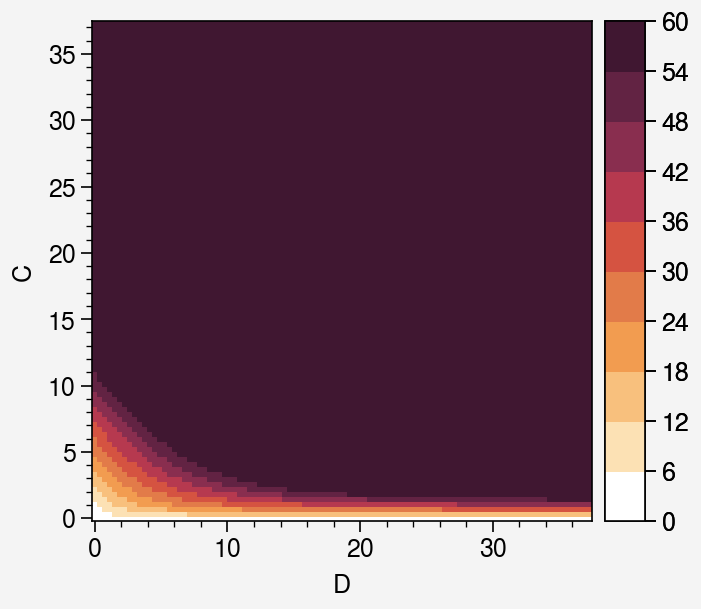

In [55]:
# Value function
fig, ax = pplt.subplots(nrows=1, ncols=1) 
n = 0
C_ex = np.linspace(0, CC[169], 20)
D_ex = C_ex*(1/K*np.log(K*R/G))/(1-1/K*np.log(K*R/G))
ax.pcolormesh(DD[0:100], CC[0:100], U[n, 0:100, 0:100], colorbar=True, vmax=60, vmin=Cmin, shading='auto')
#ax.plot(D_ex, C_ex, color='blue')
C0 = CC[np.where((U[n, :, 0] - 24)<0, np.inf, U[n, :, 0] - 24).argmin() - 1][0]
#ax.plot([0, C0], [C0, 0], color='green', linestyle = 'dotted')
ax.format(xlabel='D', ylabel='C')

C:\Users\camer\anaconda3\lib\site-packages\proplot\axes\plot.py:1275: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = getattr(super(), name)(*args, **kwargs)


<a list of 1 Line2D objects>

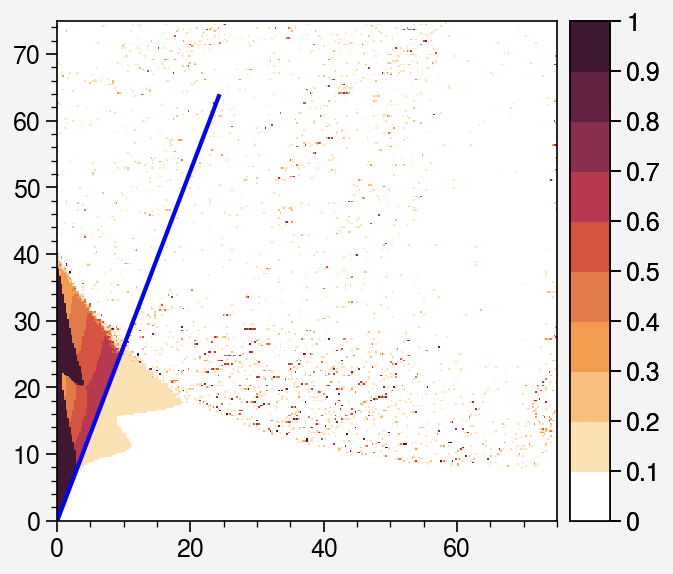

In [90]:
# Controls
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.pcolormesh(DD, CC, A[10], colorbar=True)
ax.plot(D_ex, C_ex, color='blue')

In [100]:
# Control synthesis - interpolation of best choices from PDE solving
C_current = 3
C_traj = [C_current]
D_current = 0
D_traj = [D_current]
a_traj = []
a_traj_ld = []
a_traj_lu = []
a_traj_rd = []
a_traj_ru = []
#Optimal_Value = 0
for n in range(0, tnum):
    t = tt[n]
    
    left_neighb = int(np.floor((C_current - Cmin) / h_C) + 1)
    assert(left_neighb >= 0)
    right_neighb = int(left_neighb + 1)
    assert(right_neighb <= Cnum)
    
    down_neighb = int(np.floor((D_current - Dmin) / h_D) + 1)
    assert(down_neighb >= 0)
    up_neighb = int(down_neighb + 1)
    assert(up_neighb <= Dnum)
    
    c_right = (C_current - ( (left_neighb -1)*h_C + Cmin)) / h_C
    assert(c_right <= 1 and c_right >= 0)
    c_left = 1 - c_right
    c_up = (D_current - ( (down_neighb -1)*h_D + Dmin)) / h_D
    assert(c_up <= 1 and c_up >= 0)
    c_down = 1 - c_up
    a = c_left*c_down*A[n,left_neighb, down_neighb] \
        + c_left*c_up*A[n, left_neighb, up_neighb]\
        + c_right*c_down*A[n,right_neighb, down_neighb] \
        + c_right*c_up*A[n,right_neighb, up_neighb]
    
    #Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    C_current = C_current + tau*dC_dt(C_current, D_current, a)
    D_current = D_current + tau*dD_dt(C_current, D_current, a)
    C_traj.append(C_current)
    D_traj.append(D_current)
    a_traj.append(a)
    a_traj_ld.append(A[n,left_neighb, down_neighb])
    a_traj_lu.append(A[n, left_neighb, up_neighb])
    a_traj_rd.append(A[n,right_neighb, down_neighb])
    a_traj_ru.append(A[n,right_neighb, up_neighb])

In [101]:
# Control synthesis - best choice based on interpolation of value function
def synthesis_2(C_initial, D_initial):
    C_current = C_initial
    C_traj2 = [C_current]
    D_current = D_initial
    D_traj2 = [D_current]
    a_traj2 = []
    for n in range(0, tnum):
        t = tt[n]
    
        Best_value = -1
        Best_a = -1
        # Identify optimal control value
        for a in np.linspace(0, 1, 100):
            # Calculate new position using each control value
            C_new = C_current + tau*dC_dt(C_current, D_current, a)
            D_new = D_current + tau*dD_dt(C_current, D_current, a)
        
            # Identify C and D grid points around the new position
            i = np.where((CC - C_new)<0, np.inf, CC - C_new).argmin() - 1
            j = np.where((DD - D_new)<0, np.inf, DD - D_new).argmin() - 1
        
            # Use new position to bilinearly interpolate in U
            U_C_1 = ((CC[i+1] - C_new)/h_C) * U[n, i, j] + ((C_new - CC[i])/h_C) * U[n, i+1, j]
            U_C_2 = ((CC[i+1] - C_new)/h_C) * U[n, i, j+1] + ((C_new - CC[i])/h_C) * U[n, i+1, j+1]
            U_int = ((DD[j+1] - D_new)/h_D) * U_C_1 + ((D_new - DD[j])/h_D) * U_C_2
        
            if U_int > Best_value:
                Best_value = U_int
                Best_a = a
    
        # Use best control to update position
        C_current = C_current + tau*dC_dt(C_current, D_current, Best_a)
        D_current = D_current + tau*dD_dt(C_current, D_current, Best_a)
        C_traj2.append(C_current)
        D_traj2.append(D_current)
        a_traj2.append(Best_a)
    
    return C_traj2, D_traj2, a_traj2

C_traj2, D_traj2, a_traj2 = synthesis_2(3, 0)

In [102]:
# Optimal control from Yamamura and Tsuji, 1995
C_current = 3
C_traj_sample = [C_current]
D_current = 0
D_traj_sample = [D_current]
a_traj_sample = []
#Optimal_Value = 0
x_opt = 1/K * np.log(K*R/G)
t_1 = x_opt / (G*(1-x_opt))
for n in range(0, tnum):
    t = tt[n]
    a=0
    if t < t_1:
        a = 1
    elif t < 30:
        a = x_opt
    else:
        a = 0
    #Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    C_current = C_current + tau*dC_dt(C_current, D_current, a)
    D_current = D_current + tau*dD_dt(C_current, D_current, a)
    C_traj_sample.append(C_current)
    D_traj_sample.append(D_current)
    a_traj_sample.append(a)

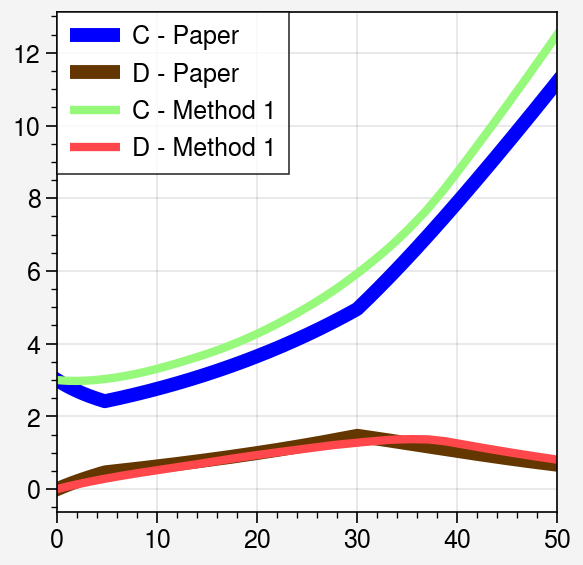

In [107]:
# Trajectories of C and D over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, C_traj_sample[:-1], color = 'blue', linewidth=5, label='C - Paper')
ax.plot(tt, D_traj_sample[:-1], color = 'brown', linewidth=5, label='D - Paper')
        
ax.plot(tt, C_traj[:-1], color='light green', linewidth=3, label='C - Method 1')
ax.plot(tt, D_traj[:-1], color='light red', linewidth=3, label='D - Method 1')     

#ax.plot(tt, C_traj2[:-1], color='yellow', linewidth=3, label='C - HJB')
#ax.plot(tt, D_traj2[:-1], color='pink', linewidth=3, label='D - HJB')    

ax.legend(loc='upper left', ncols=1)

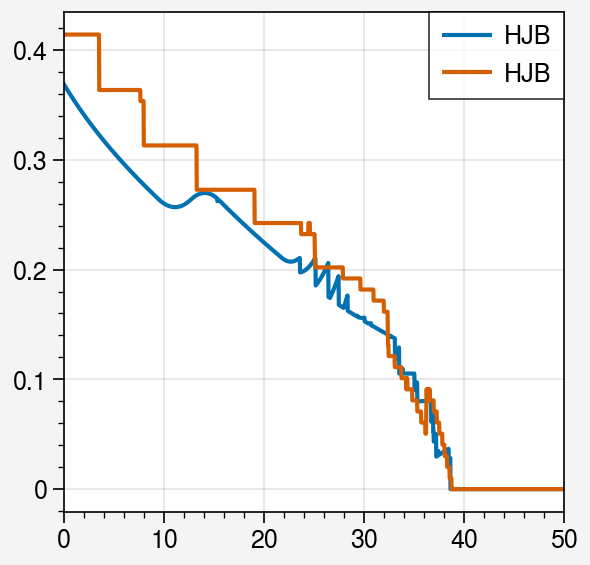

In [108]:
# Control function over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, a_traj, label='HJB')
ax.plot(tt, a_traj2, label='HJB')
#ax.plot(tt, a_traj_sample, label='Paper')

ax.legend(loc='upper right', ncols=1)

<a list of 1 Line2D objects>

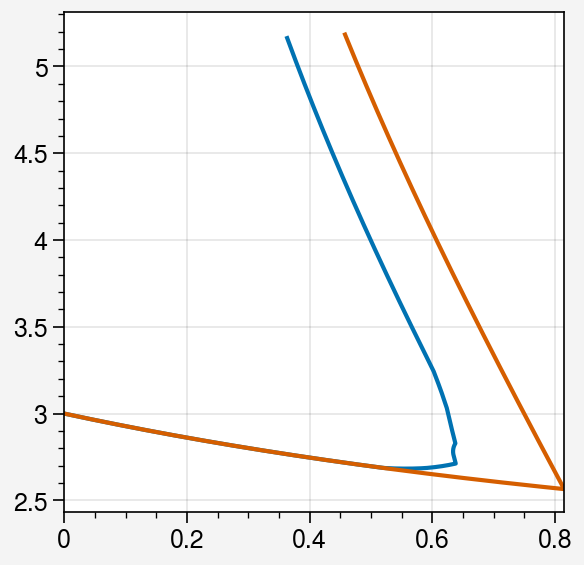

In [316]:
# Trajectories in C and D space
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(D_traj, C_traj)
ax.plot(D_traj_sample, C_traj_sample)

## Randomly changing herbivory model
As a simple addition to the model, we will incorporate an increase to herbivory that occurs at a continuously distributed, random time $\hat{T}$ with pdf $g(t)$ for $0 \leq t \leq T$. This can be easily modelled as a randomly terminating optimal control problem with a terminal cost $q(C, D, t) = u(C, D, t)$, and all other dynamics/costs as stated above. Then for a given feedback control $b(C, D, t)$ policy, define the cost as 
$$\hat{J}(C, D, t, b(\cdot, \cdot, \cdot)) = \mathbb{E}_{\hat{T}} \left \{ \int_t^{\hat{T}} K(C(s), D(s), b(C(s), D(s), s)) ds + q(C(\hat{T}), D(\hat{D}), \hat{D}) | \hat{T} > t \right\} = \mathbb{E}_{\hat{T}} \left\{q(C(\hat{T}), D(\hat{D}), \hat{D}) | \hat{T} > t \right \}$$
and optimal value $v(C, D, t)$:
$$v(C, D, t) = \sup_{b(\cdot, \cdot, \cdot)} \hat{J}(C, D, t, b(\cdot, \cdot, \cdot))$$
Applying standard arguments yields the HJB PDE
$$0 = v_t + g(t)(u(C, D, t) - v(C, D, t)) + \max_{b \in [0, 1]} \left \{ v_C \frac{dC}{dt} + v_D \frac{dD}{dt} \right \}$$
which can be  discretized in the same way as above.

In [338]:
R = 0.03
def f(t):
    return np.exp(-t)
def F(t):
    return 1 - np.exp(-t)

In [339]:
# Define numerical bounds for the control space
bmin = 0
bmax = 1 
bnum = 20
bb = np.linspace(amin, amax, anum)
B = -amin*np.ones((tnum, Cnum, Dnum))

# Initialize solutions for best value and best control
big_num = 1_000_000        # A placeholder for infinity to ensure proper computations
V = -big_num*np.ones((tnum, Cnum, Dnum)) # Initialize so ANY initial trajectory is accepted
V[tnum-1, :] = CC # Final time step is initialized with exit costs

In [340]:
# Start at the final time, and calulate in reverse
for n in range(tnum-2, -1, -1):
    # Set code up for vectorization
    t = tt[n]
    V_future = V[n+1, :, :]
    V_future_left = np.vstack(([[-big_num]*Dnum], V[n+1, :-1, :]))
    V_future_right = np.vstack((V[n+1, 1:, :], [[-big_num]*Dnum]))
    V_future_down = np.hstack(([[-big_num]]*(Cnum), V[n+1, :, :-1]))
    V_future_up = np.hstack((V[n+1, :, 1:], [[-big_num]]*(Cnum)))
    BestVal = -np.inf * np.ones((CC.size, DD.size))
    BestB = (bmin-1) * np.ones((CC.size, DD.size))
    
    for b in bb: # Test every possible control value to determine best one for each point
        dCC = dC_dt(CC, DD, b)
        dCC[0,0] = 0
        dDD = dD_dt(CC, DD, b)
        dDD[0,0] = 0
        shift_C = tau * dCC
        shift_D = tau * dDD
        
        # Sanity check, CFL should be satisfied
        assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)
        
        # Determine direction (left/right and up/down that a point should be moving towards)
        dir_left = (shift_C < 0)
        dir_left[0, :] = 0 # Cannot move out of region
        dir_right = 1-dir_left
        dir_down = (shift_D < 0)
        dir_down[:, 0] = 0 # Cannot move out of region
        dir_up = 1-dir_down
        # Domain should be 'invariant' as time marches forward (there is an artificial maximum introduced by computational limitations)
        assert((shift_C[0, :] >= 0).all())
        assert((shift_D[:, 0] >= 0).all())

        
        p_C = np.abs(shift_C)/h_C   # probability of traveling in C direction
        p_D = np.abs(shift_D)/h_D   # Probability of traveling in D direction
        p_this = 1 - p_C - p_D      # Probability of staying still
        
        Val = dir_left * (p_C * V_future_left) \
            + dir_right * (p_C * V_future_right) \
            + dir_up * (p_D * V_future_up) \
            + dir_down * (p_D * V_future_down) \
            + p_this * V_future
        
        new_best = (Val > BestVal)
        BestVal[new_best] = Val[new_best]
        BestB[new_best] = b
        
    V[n] = BestVal + f(t)*(U[n+1] - V[n+1]) / (1 - F(t)) 
    B[n] = BestB

C:\Users\camer\AppData\Local\Temp\ipykernel_11344\489065201.py:9: RuntimeWarning: invalid value encountered in divide
  return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C
C:\Users\camer\AppData\Local\Temp\ipykernel_11344\489065201.py:12: RuntimeWarning: invalid value encountered in divide
  return G*C*(a-alpha*a) - R*np.exp(-K*D/(C+D))*D
C:\Users\camer\AppData\Local\Temp\ipykernel_11344\884227625.py:22: RuntimeWarning: divide by zero encountered in divide
  assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)


C:\Users\camer\anaconda3\lib\site-packages\proplot\colors.py:2281: RuntimeWarning: overflow encountered in multiply
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
C:\Users\camer\anaconda3\lib\site-packages\proplot\colors.py:2281: RuntimeWarning: invalid value encountered in divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


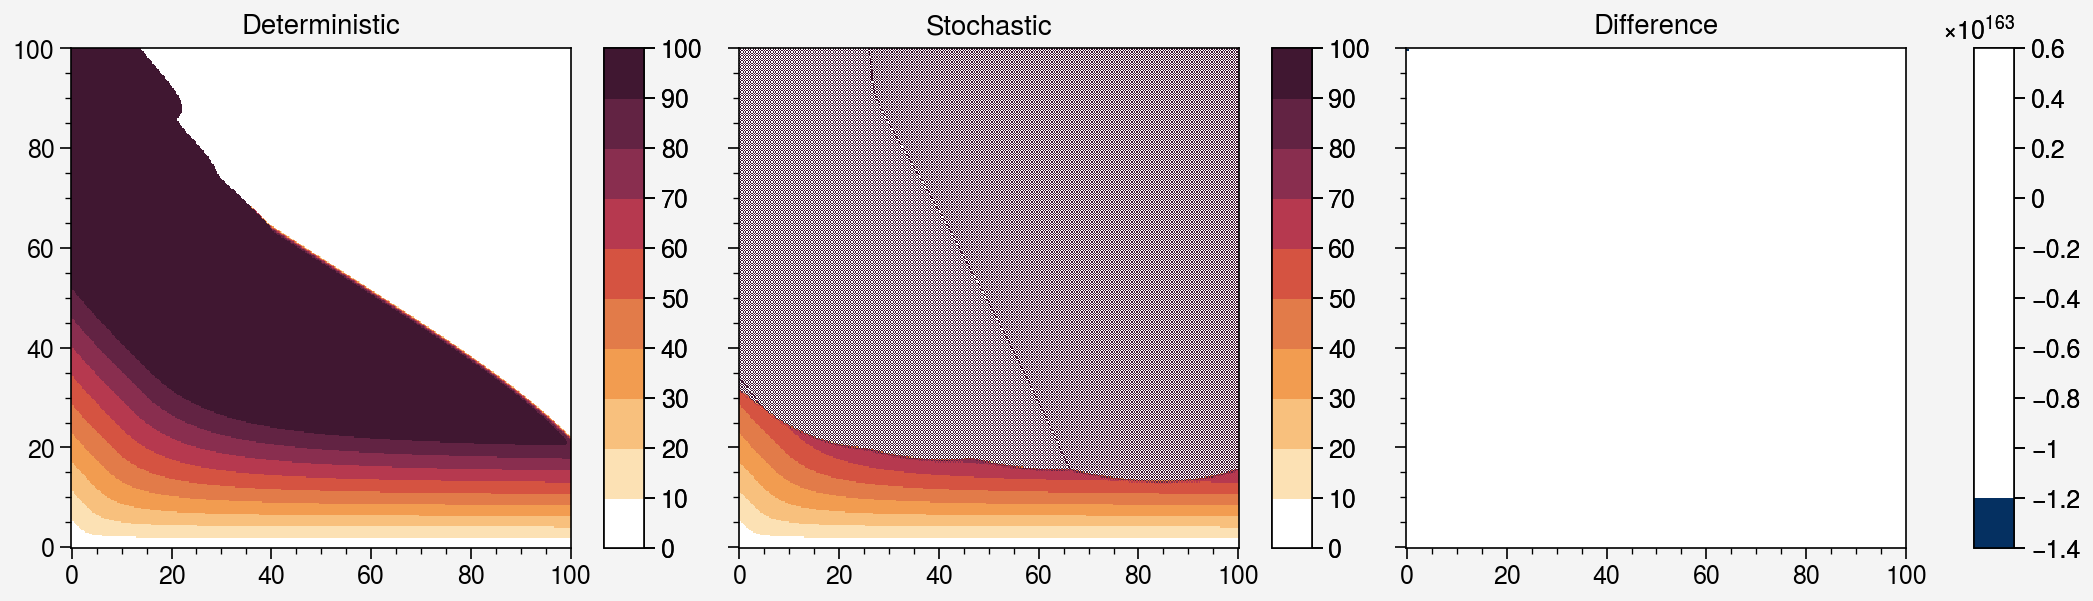

In [341]:
fig, axes = pplt.subplots(nrows=1, ncols=3)

axes[0].pcolormesh(DD, CC, U[0], colorbar=True, vmax=Cmax, vmin=Cmin, shading='auto')
axes[0].format(title='Deterministic')
axes[1].pcolormesh(DD, CC, V[0], colorbar=True, vmax=Cmax, vmin=Cmin, shading='auto')
axes[1].format(title='Stochastic')
axes[2].pcolormesh(DD, CC, U[0] - V[0], colorbar=True, shading='auto')
axes[2].format(title='Difference')

In [342]:
np.count_nonzero(U[-1] - V[-1])

0

In [343]:
C_current = 3.01003344
C_traj = [C_current]
D_current = 0
D_traj = [D_current]
b_traj = []
#Optimal_Value = 0
for n in range(0, tnum):
    t = tt[n]
    
    left_neighb = int(np.floor((C_current - Cmin) / h_C) + 1)
    assert(left_neighb >= 0)
    right_neighb = int(left_neighb + 1)
    assert(right_neighb <= Cnum)
    
    down_neighb = int(np.floor((D_current - Dmin) / h_D) + 1)
    assert(down_neighb >= 0)
    up_neighb = int(down_neighb + 1)
    assert(up_neighb <= Dnum)
    
    c_right = (C_current - ( (left_neighb -1)*h_C + Cmin)) / h_C
    assert(c_right <= 1 and c_right >= 0)
    c_left = 1 - c_right
    c_up = (D_current - ( (down_neighb -1)*h_D + Dmin)) / h_D
    assert(c_up <= 1 and c_up >= 0)
    c_down = 1 - c_up
    b = c_left*c_down*B[n,left_neighb, down_neighb] \
        + c_left*c_up*B[n, left_neighb, up_neighb]\
        + c_right*c_down*B[n,right_neighb, down_neighb] \
        + c_right*c_up*B[n,right_neighb, up_neighb]
    
    #Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    C_current = C_current + tau*dC_dt(C_current, D_current, b)
    D_current = D_current + tau*dD_dt(C_current, D_current, b)
    C_traj.append(C_current)
    D_traj.append(D_current)
    b_traj.append(b)

<a list of 1 Line2D objects>

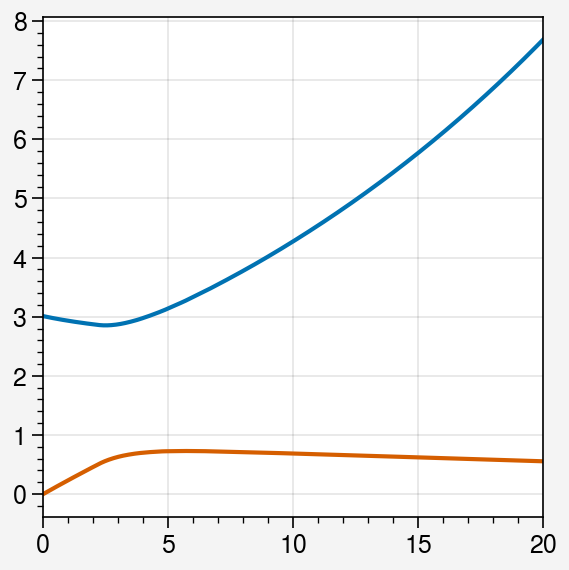

In [344]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, C_traj[:-1])
ax.plot(tt, D_traj[:-1])

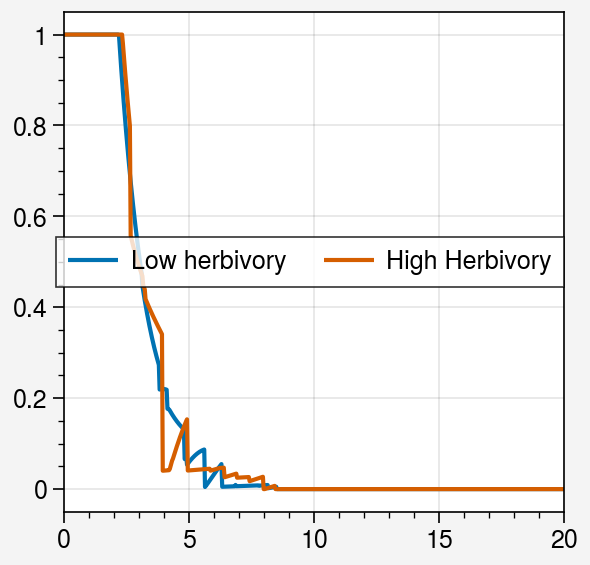

In [345]:
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, b_traj, label='Low herbivory')
ax.plot(tt, a_traj, label='High Herbivory')
ax.legend()